In [20]:
import wandb
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import runs_store as rs

plt.rcParams['figure.dpi'] = 100

In [21]:
def aggregate_runs(runs: pd.DataFrame, groupby="size"):
    runs = runs.groupby([groupby]).min().reset_index()
    int_cols = ["size", "epoch", "nodes", "gpus", "batch_size"]
    runs[int_cols] = runs[int_cols].astype(int)
    return runs

def load_group(group, partitions=["alpha", "hpdlf", "gpu2"]):
    result = {}
    for p in partitions:
        print(f"Loading {group}, {p}")
        runs = rs.load_runs(f"../data/runs/orlopau/{p}/{group}.pickle")
        runs = rs.reduce_runs(runs).sort_values("size").reset_index(drop=True)
        result[p] = aggregate_runs(runs)

    return result

load_group("srun_nccl")["gpu2"].head()

Loading srun_nccl, alpha
Loading srun_nccl, hpdlf
Loading srun_nccl, gpu2


,size,epoch,nodes,gpus,batch_size,time_sync_mean,time_sync_sum_mean,acc_test_min,acc_train_min,time_train_min,time_epoch_min,time_test_min,gpu_power,gpu_usage,gpu_mem,gpu_mem_usage
0,1,19,1,1,75,0.000013,0.131160,0.001722,0.001606,43.217045,48.618132,5.400284,37.221304,43.865347,4.821458,5.497585
1,2,19,1,2,75,0.001333,6.665688,0.001511,0.001905,32.997363,35.673385,2.683188,34.584364,32.757653,5.946642,3.734694
2,3,19,1,3,75,0.001489,4.963980,0.001859,0.002158,23.193875,25.225807,2.023301,37.447838,31.052390,5.968018,3.572072
3,4,19,1,4,75,0.001826,4.565598,0.002316,0.002444,18.365423,19.940565,1.575293,36.693040,30.872922,5.950000,3.495249
4,5,19,2,2,75,0.001920,3.839626,0.002023,0.002622,15.067153,16.403778,1.323239,37.258006,30.937861,5.941860,3.442197


In [22]:
from sklearn.linear_model import LinearRegression

plot_args = {"linewidth": 1.2, "marker": "o", "markersize": 2.5}

class BaseVariant:
    INDIVIDUAL = 1,
    INDIVIDUAL_NO_HVD = 2,
    GROUP = 3,


def calc_base_time(dfs):
    times = [df.loc[df["size"] == 1]["time_train_min"].mean() for df in dfs]
    return np.max(times)


def plot_ahmdahl(ax, x, parallel_parts=[0.8, 0.9, 1]):
    """
    Plots the Ahmdahl speedup according to ahmdahl's law.
    """
    for parallel_part in parallel_parts:
        ax.plot(x,
                1 / (1 - parallel_part + parallel_part / x),
                label=f"{parallel_part*100:.0f}% parallel",
                linewidth=.7,
                linestyle="dashed")


def plot_speedup_sequential(ax, groups, base=BaseVariant.INDIVIDUAL_NO_HVD, regression=True, prefix="", base_times=None):
    """
    Plots the speedup of the given runs compared to the base run.
    """

    ax.set_ylabel("speedup")
    ax.set_xlabel("# of GPUs")
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    if base == BaseVariant.GROUP:
        base_time = calc_base_time(groups.values())
    for name, df in groups.items():
        if base == BaseVariant.INDIVIDUAL:
            base_time = calc_base_time([df])
        elif base == BaseVariant.INDIVIDUAL_NO_HVD:
            base_time = base_times[name]

        df = aggregate_runs(df)
        df = df.sort_values(by="size")

        speedup = base_time / df["time_train_min"].to_numpy()
        max_speedup = np.max(speedup)
        x = df["size"].to_numpy()

        l = ax.plot(x, speedup, label=prefix + name, **plot_args)[0]
        if regression:
            # plot linear speedup
            reg = LinearRegression()
            reg.fit(x.reshape(-1, 1), speedup)

            print(f"{prefix} {name} speedup: {float(reg.coef_)}")

            ax.plot(x.reshape(-1, 1),
                    reg.predict(x.reshape(-1, 1)),
                    label=f"{float(reg.coef_):.2f}*GPUs",
                    linewidth=plot_args["linewidth"],
                    linestyle="dashdot",
                    color=l.get_color())

    x = np.floor(ax.get_xlim()[1]).astype(int)
    ax.plot(np.arange(1, x + 1),
            np.arange(1, x + 1),
            linewidth=plot_args["linewidth"],
            linestyle="dashdot",
            label="Ideal")
    ax.legend()

    ax.set_ylim(0, 10)


def plot_efficiency(ax, groups, base=BaseVariant.INDIVIDUAL_NO_HVD, prefix="", base_times=None):
    ax.set_ylabel("efficiency")
    ax.set_xlabel("# of GPUs")
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    if base == BaseVariant.GROUP:
        base_time = calc_base_time(groups.values())
    for name, df in groups.items():
        df = aggregate_runs(df)
        if base == BaseVariant.INDIVIDUAL:
            base_time = calc_base_time([df])
        elif base == BaseVariant.INDIVIDUAL_NO_HVD:
            base_time = base_times[name]
        df = df.sort_values(by="size")

        efficiency = (base_time / df["size"]) / df["time_train_min"]
        x = df["size"]

        ax.plot(x, efficiency, label=f"{prefix}{name}", **plot_args)

    max_x = int(ax.get_xlim()[1])
    min_x = int(ax.get_xlim()[0]) + 1
    ax.plot(np.arange(min_x, max_x),
            np.ones((max_x - min_x)),
            linewidth=plot_args["linewidth"],
            linestyle="dashdot",
            label="Ideal")
    ax.legend(loc=1)
    ax.set_ylim(0.1, 1.1)


def plot_step_time(ax, run_dfs):
    ax.set_ylabel("step time (ms)")
    ax.set_xlabel("# of gpus")

    for name, df in run_dfs.items():
        df = aggregate_runs(df)
        df.sort_values(by="size", inplace=True)
        x = df["size"]
        y = (df["time_sync_mean"]) * 1000

        ax.plot(x, y, label=f"{name}", **plot_args)

    ax.legend(loc=4)


def plot_synchro_time(ax, run_dfs):
    ax.set_ylabel("synchronization time (ms)")
    ax.set_xlabel("number of gpus")

    for name, df in run_dfs.items():
        df = aggregate_runs(df)
        df.sort_values(by="size", inplace=True)
        x = df["size"]
        base = df["time_sync_mean"][0]
        y = (df["time_sync_mean"] - base) * 1000

        ax.plot(x, y, label=f"{name}", **plot_args)

    ax.legend(loc=4)


def plot_train_time(ax, groups):
    ax.set_ylabel("train time (s)")
    ax.set_xlabel("# of GPUs")

    for name, df in groups.items():
        df = aggregate_runs(df)
        x = df["size"]
        y = df["time_train_min"]

        ax.plot(x, y, label=f"{name}", **plot_args)

    ax.legend(loc=1)


def plot_gpu_usage(groups):
    fig, axs = plt.subplots(2, figsize=(6, 6), sharex=True)
    fig.suptitle("GPU Usage vs. # of GPUs")

    (ax_gpu, ax_gpu_watt) = axs
    for name, df in groups.items():
        df = aggregate_runs(df)
        df = df.sort_values(by="size").reset_index()
        x = df["size"]

        ax_gpu.plot(x, df["gpu_usage"], label=f"{name}", **plot_args)
        ax_gpu_watt.plot(x, df["gpu_power"], label=f"{name}", **plot_args)

    ax_gpu_watt.set_ylabel("gpu power (%)")
    axs[0].legend()
    ax_gpu.set_ylabel("gpu usage (%)")

    for ax in axs:
        ax.grid()
        ax.set_xlabel("number of gpus")
        ax.set_ylim(0, 100)

    fig.tight_layout()


def plot_step_time_epoch(ax, run_dfs):
    ax.set_ylabel("synchronization time per epoch (s)")
    ax.set_xlabel("number of gpus")

    ax_batches = ax.twinx()
    ax_batches.set_ylabel("batches per epoch")
    x = np.arange(17)
    ax_batches.plot(x, (750000 / x) / 75,
                    label="batches per epoch",
                    linewidth=plot_args["linewidth"],
                    linestyle="dashdot",
                    color="black")
    ax_batches.legend(loc=3)

    for name, df in run_dfs.items():
        df = aggregate_runs(df)
        df.sort_values(by="size", inplace=True)
        x = df["size"]
        base = df.iloc[0]["time_sync_mean"]
        y = (df["time_sync_mean"] - base) * ((750000 / x) / 75)

        ax.plot(x[1:], y[1:], label=f"{name}", **plot_args)

    ax.legend()


def plot_communication_share(ax, groups):
    ax.set_ylabel("synchronization time share (%)")
    ax.set_xlabel("number of gpus")

    for name, df in groups.items():
        df = aggregate_runs(df)
        df.sort_values(by="size", inplace=True)
        x = df["size"]
        base_time_share = df.iloc[0]["time_sync_sum_min"] / df.iloc[0]["time_train_min"]
        y = (df["time_sync_sum_min"]) / df["time_train_min"] - base_time_share
        y *= 100
        ax.plot(x, y, label=f"{name}", **plot_args)

    ax.legend()


def plot_all(groups):
    fig, (ax, ax1) = plt.subplots(2, figsize=(6, 6))
    fig.suptitle("Speedup and Efficiency vs. # of GPUs")
    ax.grid()
    ax1.grid()

    plot_speedup_sequential(ax, groups, base_group=False)
    plot_efficiency(ax1, groups)

    fig.tight_layout()

    fig, ax = plt.subplots(1)
    fig.suptitle("Train time vs. # of GPUs")
    ax.grid()

    plot_train_time(ax, groups)

    fig.tight_layout()

    plot_gpu_usage(groups)

    fig, ax = plt.subplots(1)
    ax.grid()
    fig.suptitle("Gradient synchronization time vs. # of GPUs")
    plot_synchro_time(ax, groups)

    fig, ax = plt.subplots()
    ax.grid()
    plot_communication_share(ax, groups)
    fig, ax = plt.subplots()
    ax.grid()
    plot_step_time_epoch(ax, groups)
    fig, ax = plt.subplots()
    ax.grid()
    plot_step_time(ax, groups)


# nccl_sequential = load_group("nccl_sequential")
# plot_all(nccl_sequential)

# mpi_sequential = load_group("mpi_sequential", partitions=["alpha", "hpdlf"])
# plot_all(mpi_sequential)

Loading srun_mpi, alpha
Loading srun_mpi, hpdlf
Loading srun_mpi, gpu2
Loading srun_nccl, alpha
Loading srun_nccl, hpdlf
Loading srun_nccl, gpu2
Loading srun_mpi_big, alpha
Loading srun_mpi_big, hpdlf
Loading srun_mpi_big, gpu2
Loading srun_nccl_big, alpha
Loading srun_nccl_big, hpdlf
Loading srun_nccl_big, gpu2
{'alpha': 35.92351686954498, 'hpdlf': 49.56910955905914, 'gpu2': 41.84843671321869} {'alpha': 5.421951174736023, 'hpdlf': 6.580286741256714, 'gpu2': 6.605564594268799}


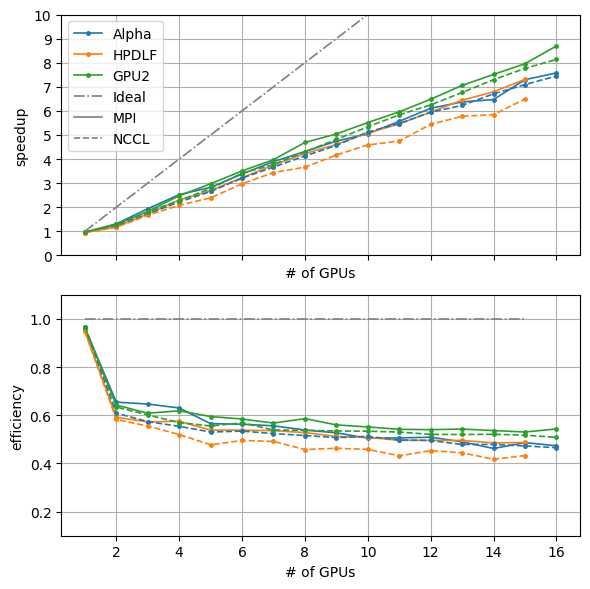

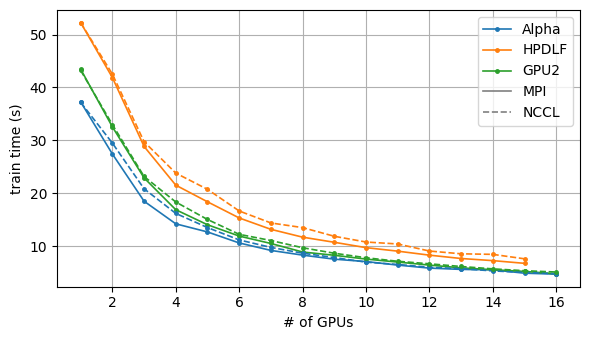

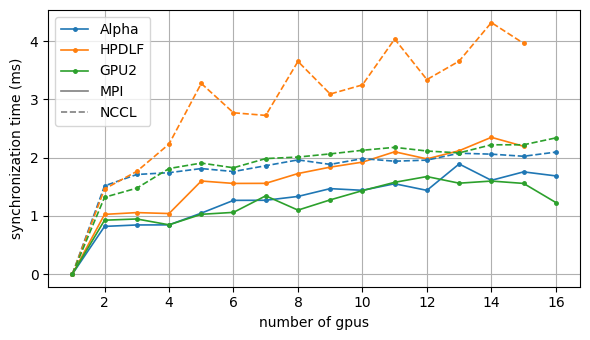

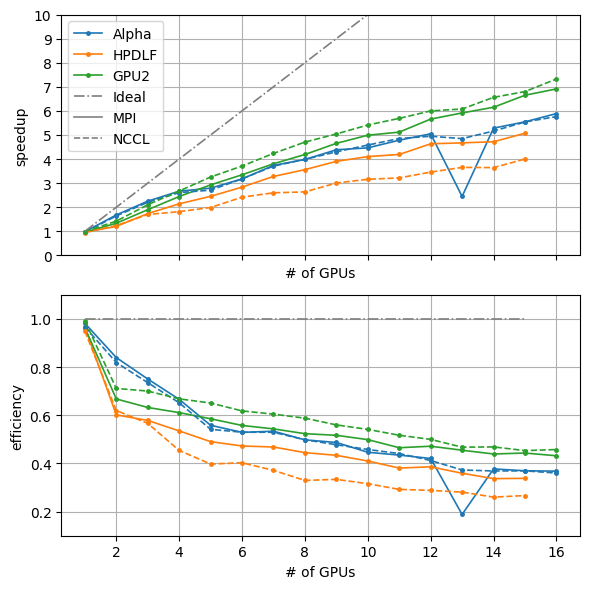

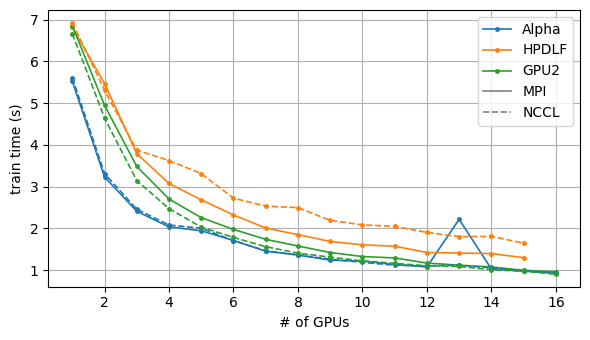

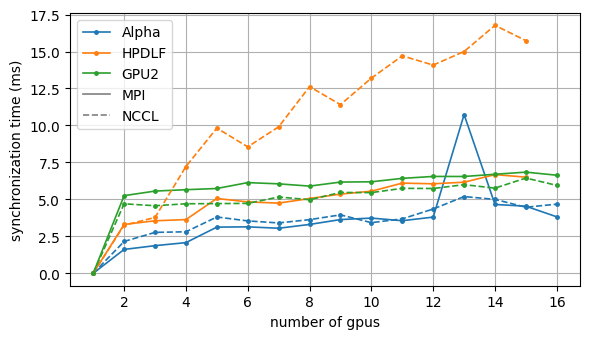

In [27]:
# generate plots for thesis

###################################################
# BATCH SIZE 75 ###################################
###################################################

def plot_multiple(plt_fnc, groups, figsize=(6,3), **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    ax.grid()
    for i, (name, group) in enumerate(groups.items()):
        plt_fnc(ax, group, **kwargs)

    ax.plot([], [], label="MPI", linewidth=plot_args["linewidth"], color="gray")
    ax.plot([], [], label="NCCL", linewidth=plot_args["linewidth"], linestyle="dashed", color="gray")

    for origin, target in zip(ax.lines[:3], ax.lines[3:]):
        target.set_color(origin.get_color())
        target.set_linestyle("dashed")
        target.set_label(None)

    ax.lines[0].set_label(ax.lines[0].get_label().capitalize())
    ax.lines[1].set_label(ax.lines[1].get_label().upper())
    ax.lines[2].set_label(ax.lines[2].get_label().upper())
    
    ax.legend()
    fig.tight_layout()
    return fig, ax

def plot_speed_eff(groups, base_times):
    fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex='all')
    for i, (name, group) in enumerate(groups.items()):
        # plot speedup based on overall slowest run
        plot_speedup_sequential(axs[0], group, base=BaseVariant.INDIVIDUAL_NO_HVD, regression=False, base_times=base_times)
        plot_efficiency(axs[1], group, base=BaseVariant.INDIVIDUAL_NO_HVD, base_times=base_times)

    for ax in axs:
        ax.lines.pop(3)
        for origin, target in zip(ax.lines[:3], ax.lines[3:]):
            target.set_color(origin.get_color())
            target.set_linestyle("dashed")

        ax.plot([], [], label="MPI", linewidth=plot_args["linewidth"], color="gray")
        ax.plot([], [], label="NCCL", linewidth=plot_args["linewidth"], linestyle="dashed", color="gray")

        for origin, target in zip(ax.lines[:3], ax.lines[3:]):
            target.set_color(origin.get_color())
            target.set_linestyle("dashed")
            target.set_label(None)

        ax.lines[0].set_label(ax.lines[0].get_label().capitalize())
        ax.lines[1].set_label(ax.lines[1].get_label().upper())
        ax.lines[2].set_label(ax.lines[2].get_label().upper())


        ax.grid()
        ax.legend()

    axs[1].get_legend().remove()

    fig.tight_layout()
    return fig, axs

def create_plots(dir, groups, base_times):
    # plot speed eff
    fig, ax = plot_speed_eff(groups, base_times)
    fig.savefig(f"./plots/{dir}/speedup_indiv_no_hvd.png", dpi=300)

    # plot train times
    fig, ax = plot_multiple(plot_train_time, groups, figsize=(6,3.5))
    fig.savefig(f"./plots/{dir}/train_times.png", dpi=300)

    # plot gradient synchronization time
    fig, ax = plot_multiple(plot_synchro_time, groups, figsize=(6,3.5))
    fig.savefig(f"./plots/{dir}/synchronization_times.png", dpi=300)

groups = {"MPI": load_group("srun_mpi"), "NCCL": load_group("srun_nccl")}
groups_big = {"MPI": load_group("srun_mpi_big"), "NCCL": load_group("srun_nccl_big")}

base_times_big = {}
base_times_small = {}

def get_min_run(p, name):
    runs = rs.load_runs(f"../data/runs/orlopau/{p}/{name}.pickle")
    run = rs.reduce_runs(runs)
    run = run.groupby(run["batch_size"]).aggregate("min").reset_index()
    return run


for p in ["alpha", "hpdlf", "gpu2"]:
    run_big = get_min_run(p, "base_big")
    run_small = get_min_run(p, "base")
    base_times_big[p] = float(run_big["time_train_min"])
    base_times_small[p] = float(run_small["time_train_min"])

print(base_times_small, base_times_big)

create_plots("75", groups, base_times=base_times_small)
create_plots("1024", groups_big, base_times=base_times_big)

In [24]:
nccl_sequential = load_group("srun_nccl")
nccl_sequential["alpha"]

Loading srun_nccl, alpha
Loading srun_nccl, hpdlf
Loading srun_nccl, gpu2


,size,epoch,nodes,gpus,batch_size,time_sync_mean,time_sync_sum_mean,acc_test_min,acc_train_min,time_train_min,time_epoch_min,time_test_min,gpu_power,gpu_usage,gpu_mem,gpu_mem_usage
0,1,19,1,1,75,0.000014,0.136365,0.002533,0.001923,37.193480,42.034759,4.894882,15.746555,17.253408,4.539807,0.870508
1,2,19,1,2,75,0.001529,7.646520,0.001931,0.002281,29.498029,32.215511,2.704580,18.216450,8.835333,5.570000,0.404221
2,3,19,1,3,75,0.001725,5.747934,0.001444,0.001894,20.867938,22.870473,1.966989,18.423686,8.675481,5.930000,0.419071
3,4,19,1,4,75,0.001755,4.388744,0.001925,0.002322,16.213475,17.764140,1.572224,17.729978,8.619518,5.930000,0.371711
4,5,19,1,5,75,0.001826,3.652538,0.003067,0.003184,13.541822,15.119859,1.561460,18.997214,11.126761,5.930000,0.403169
5,6,19,1,6,75,0.001775,2.957169,0.003153,0.003280,11.207387,12.511939,1.307204,18.570249,12.626904,5.930000,0.452736
6,7,19,1,7,75,0.001875,2.677806,0.002865,0.003270,9.793162,10.939992,1.131532,18.606184,12.706061,5.930000,0.412121
7,8,19,1,8,75,0.001975,2.468617,0.004817,0.004399,8.702848,9.745810,1.047656,18.958346,12.544118,5.930000,0.079710
8,9,19,2,4,75,0.001898,2.108356,0.003639,0.004660,7.870429,8.817258,0.954256,18.558974,15.636752,4.920000,0.004000
9,10,19,2,5,75,0.001997,1.996641,0.003198,0.004049,7.013122,7.906547,0.879994,19.097333,15.057522,4.920000,0.000000


In [25]:
batch_runs = load_group("batch_size_time", partitions=["gpu2"])["gpu2"]
batch = load_group("batch_size", partitions=["gpu2"])["gpu2"]

batch_runs = pd.concat([batch_runs, batch])

batch_runs = batch_runs.sort_values(by=["batch_size", "size"]).reset_index(drop=True)
df = batch_runs

fig, ax = plt.subplots()
ax.grid()
ax.set_ylabel("mean squared error")
ax.set_xlabel("# of GPUs")
ax.set_yscale("log")
fig.suptitle("Test MSE vs. GPUs, adjusted LR")

for bs in df["batch_size"].unique():
    df_bs = df[df["batch_size"] == bs]
    df_bs = df_bs.sort_values(by="size").reset_index(drop=True)
    x = df_bs["size"]
    y = df_bs["acc_test_min"]
    if bs == 750:
        l = f"bs: {bs}, adjusted lr"
    else:
        l = f"bs: {bs}"
    ax.plot(x, y, label=l, linewidth=1.5, marker="o", markersize=4)
    ax.legend()
fig.tight_layout()

Loading batch_size_time, gpu2


FileNotFoundError: [Errno 2] No such file or directory: '../data/runs/orlopau/gpu2/batch_size_time.pickle'

In [ ]:
runs = [*rs.load_runs("../data/runs/orlopau/gpu2/batch_size.pickle"), *rs.load_runs("../data/runs/orlopau/gpu2/batch_size_time.pickle")]
runs = pd.DataFrame.from_dict([rs.run_to_reduced_dict(r) for r in runs])
runs

FileNotFoundError: [Errno 2] No such file or directory: '../data/runs/orlopau/gpu2/batch_size.pickle'

NameError: name 'runs' is not defined

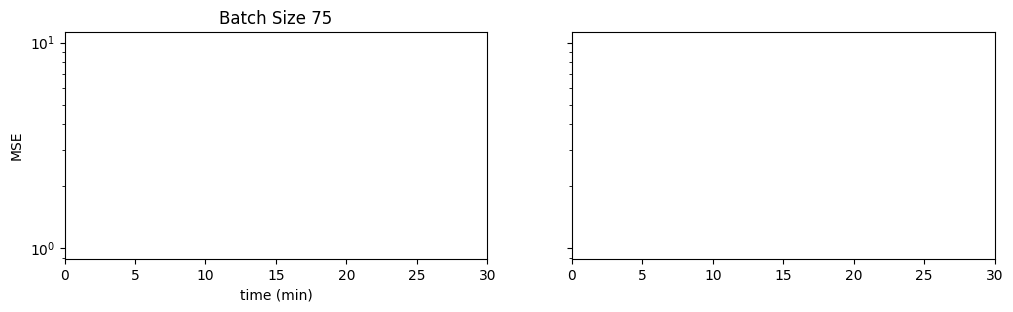

In [ ]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12,3))

for bs, ax in zip([75,750], axs.flatten()):
    ax.set_yscale("log")
    ax.set_ylabel("MSE")
    ax.set_xlabel("time (min)")
    ax.set_title(f"Batch Size {bs}")
    ax.set_xlim(0, 30)
    bs_runs = runs[runs["batch_size"] == bs][runs["size"].isin([1,2,4,8])]
    bs_runs = bs_runs.sort_values(by="size").reset_index(drop=True)
    for r in bs_runs.itertuples():
        if bs == 750:
            ax.plot(r.history["time"] / 60, r.history["acc_test"].rolling(window=1, closed="right").mean(), label=f"{r.size} GPUs")
        else:
            ax.plot(r.history["time"] / 60, r.history["acc_test"], label=f"{r.size} GPUs")
    ax.legend()

axs.flatten()[0].legend()
fig.tight_layout()